# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import os
%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from wsi_processing_pipeline.shared import enums

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/')
PATH_LABELS_TILE_PIPELINE = PATH/'labels_tile_pipeline.xlsx'
PATH_LABELS_WSI_PIPELINE = PATH/'labels_wsi_pipeline.xlsx'

PATH_TILES = PATH/'tiles'
PATH_WSIS = PATH/'wsis'


seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
import fastai
print(fastai.__version__)

import torchvision, torch
print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

2.2.1
1.7.1
0.8.2
10.2


# Data

## from preextracted tiles

### tile paths

In [85]:
tile_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH_TILES, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True)


0it [00:00, ?it/s]
4it [00:00, 19.36it/s]
6it [00:00, 14.23it/s]
7it [00:00,  4.95it/s]
8it [00:01,  5.63it/s]
9it [00:01,  5.63it/s]
10it [00:01,  4.86it/s]
11it [00:01,  4.91it/s]
13it [00:02,  4.88it/s]
14it [00:02,  2.76it/s]
15it [00:03,  3.37it/s]
16it [00:03,  3.85it/s]
17it [00:03,  3.69it/s]
19it [00:03,  4.51it/s]
21it [00:03,  5.49it/s]
22it [00:04,  4.89it/s]
23it [00:04,  5.34it/s]
24it [00:04,  3.92it/s]
27it [00:04,  4.89it/s]
28it [00:05,  5.07it/s]
29it [00:05,  3.98it/s]
30it [00:05,  3.55it/s]
31it [00:06,  3.74it/s]
34it [00:06,  4.95it/s]
35it [00:06,  5.66it/s]
37it [00:06,  6.37it/s]
39it [00:06,  7.37it/s]
40it [00:07,  4.85it/s]
42it [00:08,  3.33it/s]
43it [00:08,  3.86it/s]
45it [00:08,  4.75it/s]
46it [00:08,  5.59it/s]
48it [00:08,  5.90it/s]
50it [00:09,  5.60it/s]
51it [00:09,  6.29it/s]
52it [00:09,  6.20it/s]
53it [00:09,  4.84it/s]
55it [00:10,  3.59it/s]
56it [00:11,  3.27it/s]
57it [00:11,  2.72it/s]
58it [00:11,  3.10it/s]
59it [00:12,  3.75it/s]
6

In [8]:
#tile_paths = random.sample(tile_paths, 3000)

In [88]:
len(tile_paths)

1938980

### check images

In [5]:
def check_image(path):
    try:
        open_image(path)
    except Exception as e:
        return path
        
    return None

In [ ]:
with ProcessPoolExecutor(max_workers=32) as pool:
    with tqdm(total=len(tile_paths)) as progress:
        futures = []

        for p in tile_paths:
            future = pool.submit(check_image, p)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        results = []
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                results.append(result)

In [ ]:
failed = []
for p in tqdm(tile_paths_1819):
    r = check_image(p)
    if r is not None:
        failed.append(r)

### id and label funcs

In [7]:
labels_df = pd.read_excel(PATH_LABELS_TILE_PIPELINE)

In [8]:
labels_df

patient_id   case_id    slide_id  \
0                Schwemmer-Andreas-1974-03-14   N296-08   N296-08-I   
1                Schwemmer-Andreas-1974-03-14   N296-08  N296-08-II   
2                   Ballmann-Artur-1934-06-04   N320-08     N320-08   
3                   Ballmann-Artur-1934-06-04   N320-08     N320-08   
4                     Brandt-Ernst-1941-07-14   N608-08     N608-08   
..                                        ...       ...         ...   
206          Härtl_Kaczinski-Anita-1943-01-13  N1606-18    N1606-18   
207                Heinrich-Dieter-1961-12-21  N1416-18    N1416-18   
208                  Herold-Walter-1953-11-08  N1393-18    N1393-18   
209  Novic-Stanislav_Valentinovych-1974-02-23  N1300-18    N1300-18   
210                  Kloock-Thomas-1965-02-28  N1260-18    N1260-18   

     methylation_status Unnamed: 4  
0                   0.0        NaN  
1                   0.0        NaN  
2                   0.0        NaN  
3                   0.0        NaN  
4                   0.0        NaN  
..                  ...        ...  
206                 1.0        NaN  
207                 1.0        NaN  
208                 1.0        NaN  
209                 1.0        NaN  
210                 1.0        NaN  

[211 rows x 5 columns]

In [9]:
def get_slide_id_from_parent_folder_name(parent_folder_name:str)->str:
    split = parent_folder_name.split(sep='.')
    if((len(split) == 3) or (len(split) == 2 and 'I' in split[1])):
        return f'{split[0]}-{split[1]}'
    elif(len(split) == 2):
        return split[0]#
    elif(len(split) == 1):
        return parent_folder_name
    else:
        assert False

def get_patient_id_from_parent_folder_name(parent_folder_name:str)->str:
    slide_id = get_slide_id_from_parent_folder_name(parent_folder_name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['patient_id'])[0]

def get_patient_id_from_tile_path(tile_path:pathlib.Path)->str:
    slide_id = get_slide_id_from_parent_folder_name(tile_path.parent.name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['patient_id'])[0]

def get_case_id_from_tile_path(tile_path:pathlib.Path)->str:
    slide_id = get_slide_id_from_parent_folder_name(tile_path.parent.name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['case_id'])[0]

def get_slide_id_from_tile_path(tile_path:pathlib.Path)->str:
    return get_slide_id_from_parent_folder_name(tile_path.parent.name)

def get_label_from_tile_path(tile_path:pathlib.Path)->List[int]:
    if('non_methylated' in str(tile_path)):
        return [0]
    if('methylated' in str(tile_path)):
        return [1]
    assert False

### patient manager

In [13]:
patient_manager = PatientManager()

In [14]:
patient_manager.create_from_preextracted_tiles(tile_paths=tile_paths, 
                                               patient_id_getter=get_patient_id_from_tile_path,
                                               case_id_getter=get_case_id_from_tile_path, 
                                               slide_id_getter=get_slide_id_from_tile_path, 
                                               labels_getter=get_label_from_tile_path)


  2%|▏         | 30758/1938980 [00:27<28:25, 1118.85it/s]


  3%|▎         | 61239/1938980 [00:54<27:28, 1138.96it/s]


  5%|▍         | 91795/1938980 [01:21<27:27, 1121.26it/s]


  6%|▋         | 121978/1938980 [01:48<27:13, 1112.53it/s]


  8%|▊         | 152003/1938980 [02:15<26:20, 1130.67it/s]


  9%|▉         | 182219/1938980 [02:41<25:47, 1135.05it/s]


 11%|█         | 212526/1938980 [03:08<25:21, 1134.74it/s]


 13%|█▎        | 242917/1938980 [03:35<24:43, 1143.11it/s]


 14%|█▍        | 273222/1938980 [04:03<24:35, 1128.64it/s]


 16%|█▌        | 303631/1938980 [04:29<23:49, 1144.08it/s]


 17%|█▋        | 333935/1938980 [04:56<23:28, 1139.17it/s]


 19%|█▊        | 363444/1938980 [05:23<24:15, 1082.75it/s]


 20%|██        | 392586/1938980 [05:50<23:20, 1104.05it/s]


 22%|██▏       | 421889/1938980 [06:16<23:14, 1088.26it/s]


 23%|██▎       | 451328/1938980 [06:43<22:28, 1103.33it/s]


 25%|██▍       | 480717/1938980 [07:10<22:12, 1094.65it/s]


 26%|██▋       | 510152/1938980 [07:36<21:32, 1105.65it/s]


 28%|██▊       | 539887/1938980 [08:03<21:19, 1093.25it/s]


 29%|██▉       | 569969/1938980 [08:30<21:06, 1081.26it/s]


 31%|███       | 599739/1938980 [08:57<20:01, 1114.18it/s]


 32%|███▏      | 629640/1938980 [09:24<19:30, 1118.62it/s]


 34%|███▍      | 659538/1938980 [09:50<18:57, 1124.87it/s]


 36%|███▌      | 689144/1938980 [10:17<18:27, 1128.74it/s]


 37%|███▋      | 719366/1938980 [10:44<17:41, 1149.43it/s]


 39%|███▊      | 749555/1938980 [11:10<17:33, 1129.32it/s]


 40%|████      | 779786/1938980 [11:39<17:10, 1124.52it/s]


 42%|████▏     | 809891/1938980 [12:06<16:51, 1116.61it/s]


 43%|████▎     | 839298/1938980 [12:32<16:22, 1119.52it/s]


 45%|████▍     | 868801/1938980 [12:59<16:16, 1095.44it/s]


 46%|████▋     | 898607/1938980 [13:26<15:21, 1128.74it/s]


 48%|████▊     | 928596/1938980 [13:53<14:52, 1132.44it/s]


 49%|████▉     | 958622/1938980 [14:19<14:25, 1132.92it/s]


 51%|█████     | 988856/1938980 [14:46<13:57, 1135.11it/s]


 53%|█████▎    | 1018807/1938980 [15:12<13:14, 1158.28it/s]


 54%|█████▍    | 1048889/1938980 [15:39<12:50, 1155.39it/s]


 56%|█████▌    | 1078930/1938980 [16:05<12:48, 1119.40it/s]


 57%|█████▋    | 1108638/1938980 [16:31<12:16, 1126.87it/s]


 59%|█████▊    | 1138171/1938980 [16:57<12:32, 1063.69it/s]


 60%|██████    | 1167275/1938980 [17:24<11:31, 1116.65it/s]


 62%|██████▏   | 1197124/1938980 [17:50<10:52, 1137.58it/s]


 63%|██████▎   | 1227066/1938980 [18:16<10:32, 1125.38it/s]


 65%|██████▍   | 1256637/1938980 [18:42<09:52, 1151.29it/s]


 66%|██████▋   | 1286441/1938980 [19:08<09:39, 1125.65it/s]


 68%|██████▊   | 1316060/1938980 [19:35<09:09, 1134.43it/s]


 69%|██████▉   | 1345726/1938980 [20:01<08:47, 1124.57it/s]


 71%|███████   | 1375349/1938980 [20:30<08:27, 1109.67it/s]


 72%|███████▏  | 1404536/1938980 [20:56<08:05, 1100.09it/s]


 74%|███████▍  | 1433994/1938980 [21:23<07:28, 1127.19it/s]


 75%|███████▌  | 1463590/1938980 [21:49<07:02, 1124.56it/s]


 77%|███████▋  | 1493089/1938980 [22:16<06:37, 1122.67it/s]


 79%|███████▊  | 1522593/1938980 [22:42<06:09, 1126.80it/s]


 80%|████████  | 1552401/1938980 [23:08<05:41, 1130.43it/s]


 82%|████████▏ | 1582151/1938980 [23:35<05:16, 1126.53it/s]


 83%|████████▎ | 1611747/1938980 [24:01<05:03, 1079.10it/s]


 85%|████████▍ | 1640960/1938980 [24:27<04:22, 1136.92it/s]


 86%|████████▌ | 1670443/1938980 [24:53<03:55, 1140.77it/s]


 88%|████████▊ | 1700012/1938980 [25:20<03:35, 1111.27it/s]


 89%|████████▉ | 1729811/1938980 [25:46<03:02, 1147.19it/s]


 91%|█████████ | 1758571/1938980 [26:12<02:43, 1102.76it/s]


 92%|█████████▏| 1787302/1938980 [26:39<02:19, 1086.17it/s]


 94%|█████████▎| 1816560/1938980 [27:05<01:49, 1119.71it/s]


 95%|█████████▌| 1846153/1938980 [27:31<01:22, 1127.05it/s]


 97%|█████████▋| 1875758/1938980 [27:57<00:55, 1132.49it/s]


 98%|█████████▊| 1905484/1938980 [28:24<00:29, 1131.77it/s]


100%|█████████▉| 1935157/1938980 [28:50<00:03, 1130.03it/s]


100%|██████████| 1938980/1938980 [28:53<00:00, 1118.33it/s]


In [15]:
train_size = 0.8
validation_size = 0.2
test_size = 0
patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

In [16]:
class_distribution = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [17]:
class_distribution

(1938980,
 {0: 1186057, 1: 752923},
 {0: 0.6116911984651724, 1: 0.3883088015348276})

In [18]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [19]:
class_distribution_train

(1609872,
 {0: 1028347, 1: 581525},
 {0: 0.6387756293668068, 1: 0.3612243706331932})

In [20]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [21]:
class_distribution_valid

(329108,
 {0: 157710, 1: 171398},
 {0: 0.4792043949098776, 1: 0.5207956050901223})

###  data block api

In [22]:
import PIL

In [23]:
PIL.Image.open(tile_paths[0]).shape

(272, 272)

In [24]:
final_size = 272
bs = 44

#necessary for exporting the learner as pickle file since lambda functions cannot be pickled
def get_x(tile):
    return tile.tile_path
def get_y(tile):
    return tile.labels

data = fastai.data.block.DataBlock(
        blocks=(ImageBlock, fastai.data.block.MultiCategoryBlock),
        #get_x=lambda x: x.tile_path, 
        #get_y=lambda x: x.labels,
        get_x=get_x, 
        get_y=get_y,
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai.vision.augment.Resize(final_size, method = 'squish'),
        #item_tfms = fastai.vision.augment.RandomResizedCrop(size=final_size),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

In [25]:
dls.train_ds

(#1609872) [(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.])),(PILImage mode=RGB size=272x272, TensorMultiCategory([0., 1.]))...]

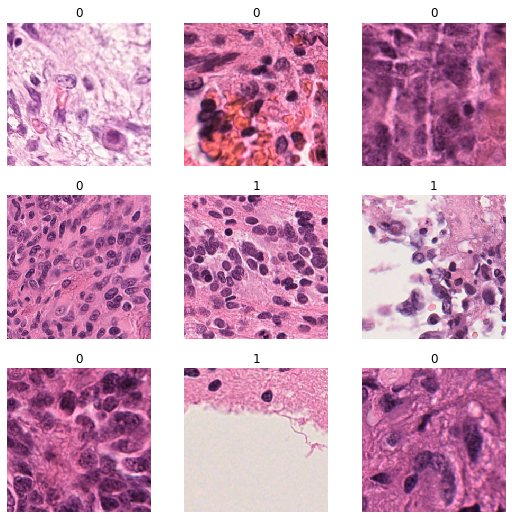

In [24]:
dls.show_batch()

## from wsis with rois saved to json files

### wsi and json paths

In [4]:
wsi_paths = fastai.data.transforms.get_files(path=PATH_WSIS, extensions=['.ndpi'])
json_paths = fastai.data.transforms.get_files(path=PATH_WSIS, extensions=['.json'])

In [5]:
print(len(wsi_paths))
print(len(json_paths))

201
201


### id, label and roi funcs

In [6]:
# https://stackoverflow.com/questions/65254535/xlrd-biffh-xlrderror-excel-xlsx-file-not-supported
df_labels = pd.read_excel(PATH_LABELS_WSI_PIPELINE, engine='openpyxl')

In [7]:
df_labels.head()

patient_id  case_id     slide_id  methylation_status  \
0  Schwemmer-Andreas-1974-03-14  N296-08  N296-08-I-1                 0.0   
1  Schwemmer-Andreas-1974-03-14  N296-08   N296-08-II                 0.0   
2     Ballmann-Artur-1934-06-04  N320-08    N320-08-4                 0.0   
3     Ballmann-Artur-1934-06-04  N320-08    N320-08-6                 0.0   
4       Brandt-Ernst-1941-07-14  N608-08      N608-08                 0.0   

  Unnamed: 4  Unnamed: 5  
0        NaN         NaN  
1        NaN         NaN  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN

In [8]:
def wsi_path_to_df_row(wsi_path:pathlib.Path, df:pd.DataFrame)->pandas.core.frame.DataFrame:
    """
    Arguments:
        wsi_path: path to whole-slide image
        df: pandas DataFrame with columns patient_id, case_id, slide_id, methylation_status
    Returns:
        The row from the dataframe where the slide_id matches the slide id in the wsi_path
    """
    if('2008-2012_methyliert' in str(wsi_path) or '2008-2012_nicht_methyliert' in str(wsi_path)):
        slide_id_from_path = wsi_path.parent.name
        row = df.loc[df['slide_id'] == slide_id_from_path]            
        return row
    if('2018_2019_methyliert' in str(wsi_path) or '2018_2019_nicht_methyliert' in str(wsi_path)):
        slide_id_from_path = wsi_path.stem
        row = df.loc[df['slide_id'] == slide_id_from_path]            
        return row
    
    assert False
    
def wsi_path_to_json_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    json_path = Path(f'{wsi_path.parent/wsi_path.stem}.json')
    if(json_path in json_paths):
        return json_path
    else:
        raise FileNotFoundError(f'json file could not be found for {wsi_path}')

In [9]:
###
##check that for every wsi_path there is exactly one entry in the dataframe and a correpsonding json file
###

#wsi_paths = fastai.data.transforms.get_files(path=PATH_WSIS, extensions=['.ndpi'])
#json_paths = fastai.data.transforms.get_files(path=PATH_WSIS, extensions=['.json'])
#for wp in wsi_paths:
#    if(len(wsi_path_to_df_row(wsi_path=wsi_path, df=df_labels)) != 1):
#        print(wsi_path)
#    wsi_path_to_json_path(wsi_path=wsi_path, json_paths=json_paths)

In [10]:
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path, df:pd.DataFrame=df_labels)->str:
    return wsi_path_to_df_row(wsi_path=wsi_path, df=df)['patient_id'].item()

def get_case_id_from_wsi_path(wsi_path:pathlib.Path, df:pd.DataFrame=df_labels)->str:
    return wsi_path_to_df_row(wsi_path=wsi_path, df=df)['case_id'].item()

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path, df:pd.DataFrame=df_labels)->str:
    return wsi_path_to_df_row(wsi_path=wsi_path, df=df)['slide_id'].item()

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None, df:pd.DataFrame=df_labels)->List[int]:
    return [int(wsi_path_to_df_row(wsi_path=wsi_path, df=df)['methylation_status'].item())]

def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = wsi_path_to_json_path(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

In [11]:
wsi_path_to_rois = {}
for wp in wsi_paths:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

### calculate tiles

In [12]:
tilesummaries = tiles.WsisToTilesParallel(wsi_paths=wsi_paths, 
                                                   tiles_folder_path=None, 
                                                   tile_height=1024, 
                                                   tile_width=1024,
                                                   tile_score_thresh=0.3,
                                                   tile_scoring_function=tiles.scoring_function_2,
                                                   return_as_tilesummary_object=True, 
                                                   wsi_path_to_rois=wsi_path_to_rois, 
                                                   minimal_tile_roi_intersection_ratio=0.8, 
                                                  verbose=False)

100%|██████████| 201/201 [13:26<00:00, 28.35s/it]

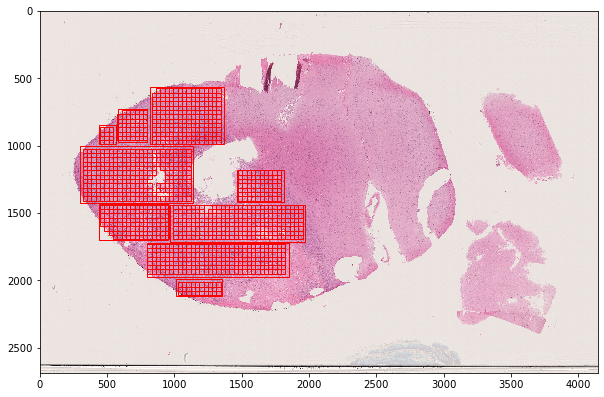

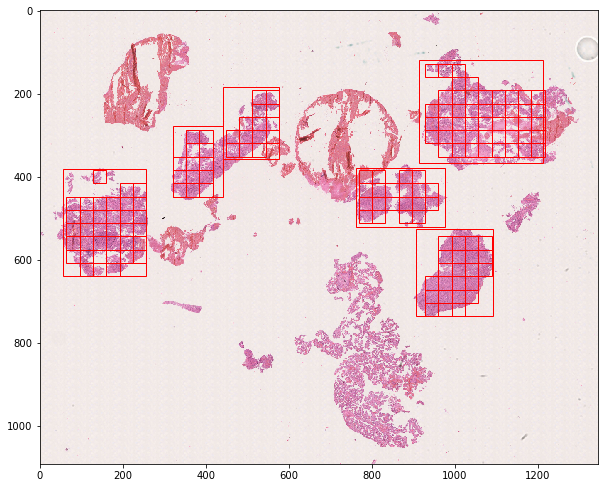

In [13]:
for ts in random.sample(tilesummaries, 2):
    ts.show_wsi_with_top_tiles()

### patient manager

#### create 

In [15]:
patient_manager = PatientManager()

In [16]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, #one case per patient
                                         case_id_getter= get_case_id_from_wsi_path, 
                                         slide_id_getter= get_slide_id_from_wsi_path, 
                                         labels_getter=get_labels_from_wsi_path)


100%|██████████| 201/201 [00:08<00:00, 24.92it/s]


In [17]:
len(patient_manager.get_all_tiles())

130634

#### split

In [18]:
train_size = 0.85
validation_size = 0.15
test_size = 0.0

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

#### class distribution

In [19]:
class_distribution_all = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [20]:
class_distribution_all

(130634, {0: 78873, 1: 51761}, {0: 0.603770840669351, 1: 0.396229159330649})

In [21]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [22]:
class_distribution_train

(111549, {0: 68323, 1: 43226}, {0: 0.6124931644389461, 1: 0.38750683556105386})

In [23]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [24]:
class_distribution_valid

(19085, {0: 10550, 1: 8535}, {0: 0.552790149331936, 1: 0.4472098506680639})

In [25]:
patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.train)

(172, {0: 95, 1: 77}, {0: 0.5523255813953488, 1: 0.4476744186046512})

### data block api

In [26]:
final_size = 512
bs = 35

data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation), 
                       bs=bs, 
                       verbose=False)

In [27]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train))

111549

In [28]:
len(dls.train_ds)

111549

In [29]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation))

19085

In [30]:
len(dls.valid_ds)

19085

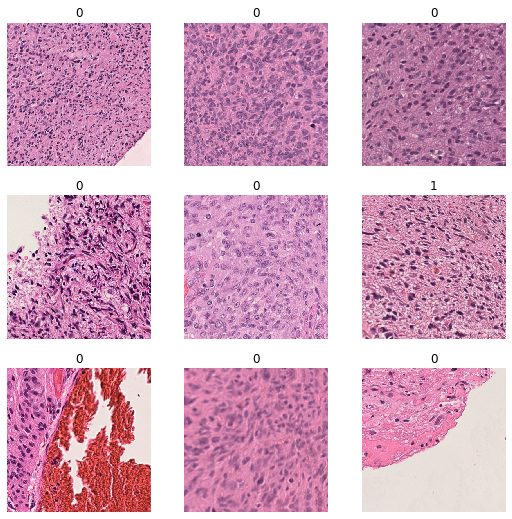

In [72]:
dls.show_batch()

# learner

## n 

In [33]:
n=3

## create

In [34]:
#arch = torchvision.models.resnet.resnext101_32x8d
arch = torchvision.models.resnet50

In [35]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [36]:
learner.to_fp16()

In [37]:
learner.path

Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/models/3-resnet50')

In [38]:
learner.path.parent.mkdir(exist_ok=True)

In [39]:
learner.path.mkdir(exist_ok=True)

## name

In [40]:
epochs_frozen = 5
epochs_unfrozen = 10

In [41]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'3-resnet50'

## train

SuggestedLRs(lr_min=0.008128305524587631, lr_steep=5.754399179380698e-09)

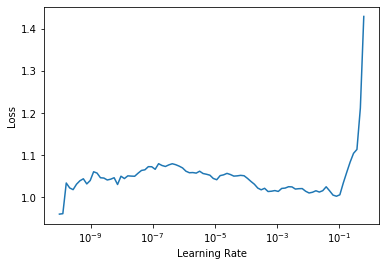

In [85]:
learner.lr_find(start_lr=1e-10, end_lr=10, num_it=100)

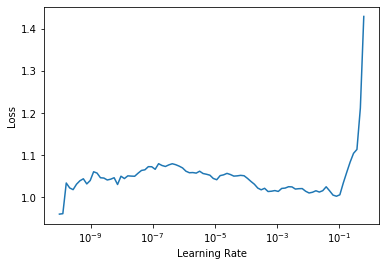

In [86]:
learner.recorder.plot_lr_find()

In [87]:
lr1 = 1e-3

In [88]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [ ]:
pd.read_csv(learner.path/log_head_name)

In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
learner.save(nameHead)

In [ ]:
#learner.load(nameHead)

In [98]:
learner.unfreeze()

SuggestedLRs(lr_min=8.165823702985243e-14, lr_steep=8.317637892460081e-14)

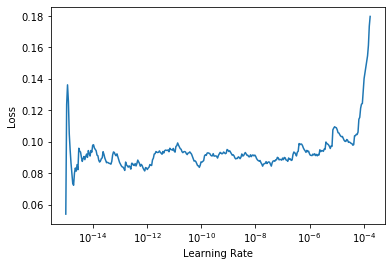

In [103]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=500)

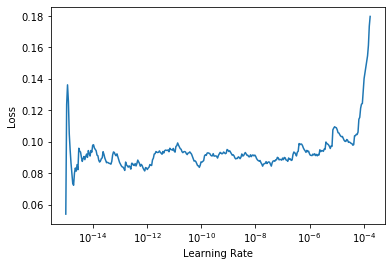

In [104]:
learner.recorder.plot_lr_find()

In [105]:
lr2 = 1e-9
lr3 = 1e-8
lr4 = 1e-7

In [106]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), 
                           SaveModelCallback(every_epoch=True, fname='complete')])

In [111]:
pd.read_csv(learner.path/log_complete_name)

epoch  train_loss  valid_loss  accuracy_multi      time
0      0    0.090038    2.918088        0.478491  11:37:47
1      1    0.089930    2.904809        0.479644   9:23:28
2      2    0.098082    2.965433        0.489442   8:17:40
3      3    0.100586    2.940251        0.488944  19:15:02
4      4    0.086761    3.016607        0.482473  15:14:06
5      5    0.099359    2.854242        0.482604  24:19:12
6      6    0.094369    2.996120        0.490778  13:59:33
7      7    0.086992    2.870451        0.473513  18:19:51
8      8    0.089482    2.835785        0.483862  17:15:52
9      9    0.107678    2.952827        0.484569  13:40:08

In [42]:
nameComplete = f'{nameBase}-complete'; nameComplete

'3-resnet50-complete'

In [43]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [55]:
from postprocessing.predictor import Predictor

In [56]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [57]:
from preprocessing import tile_image_block

In [63]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, batch_size=bs)

In [64]:
thresholds = {0:0.5, 1:0.5}
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds_tile_level = thresholds,
                                                thresholds_higher_level = thresholds)

# evaluation

In [88]:
from postprocessing.evaluator import Evaluator
evaluator = Evaluator(predictor=predictor)

In [89]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.slide)


100%|██████████| 29/29 [00:00<00:00, 1012.70it/s]


{0: 0.6206896551724138, 1: 0.6206896551724138}

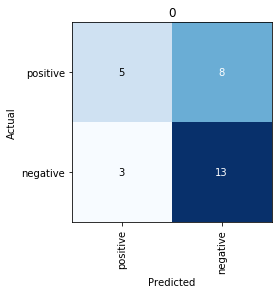

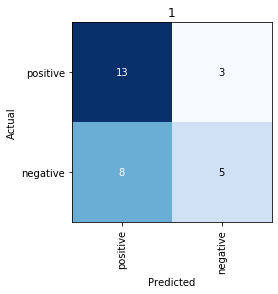

In [90]:
evaluator.plot_confusion_matrix(dataset_type=shared.enums.DatasetType.validation, 
                                level=shared.enums.EvaluationLevel.case)


  0%|          | 0/2 [00:00<?, ?it/s]

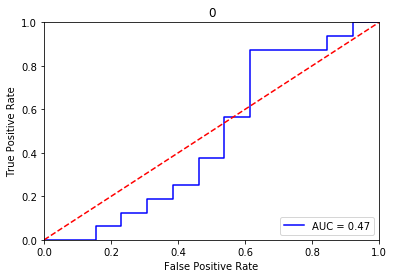


 50%|█████     | 1/2 [00:00<00:00,  3.99it/s]

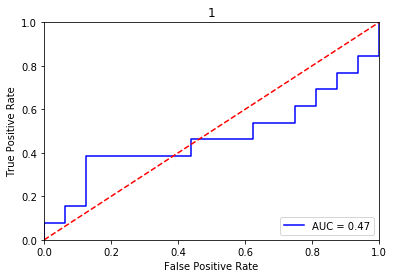


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


In [91]:
evaluator.plot_roc_curves(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.case)


  0%|          | 0/2 [00:00<?, ?it/s]

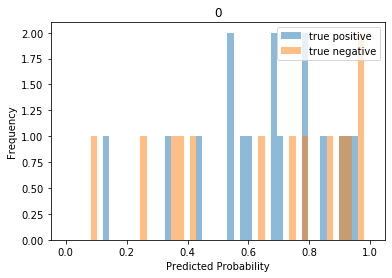


 50%|█████     | 1/2 [00:00<00:00,  1.92it/s]

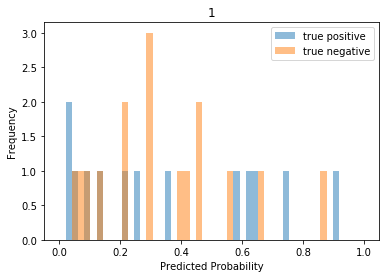


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


In [92]:
evaluator.plot_probability_histograms(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.case)

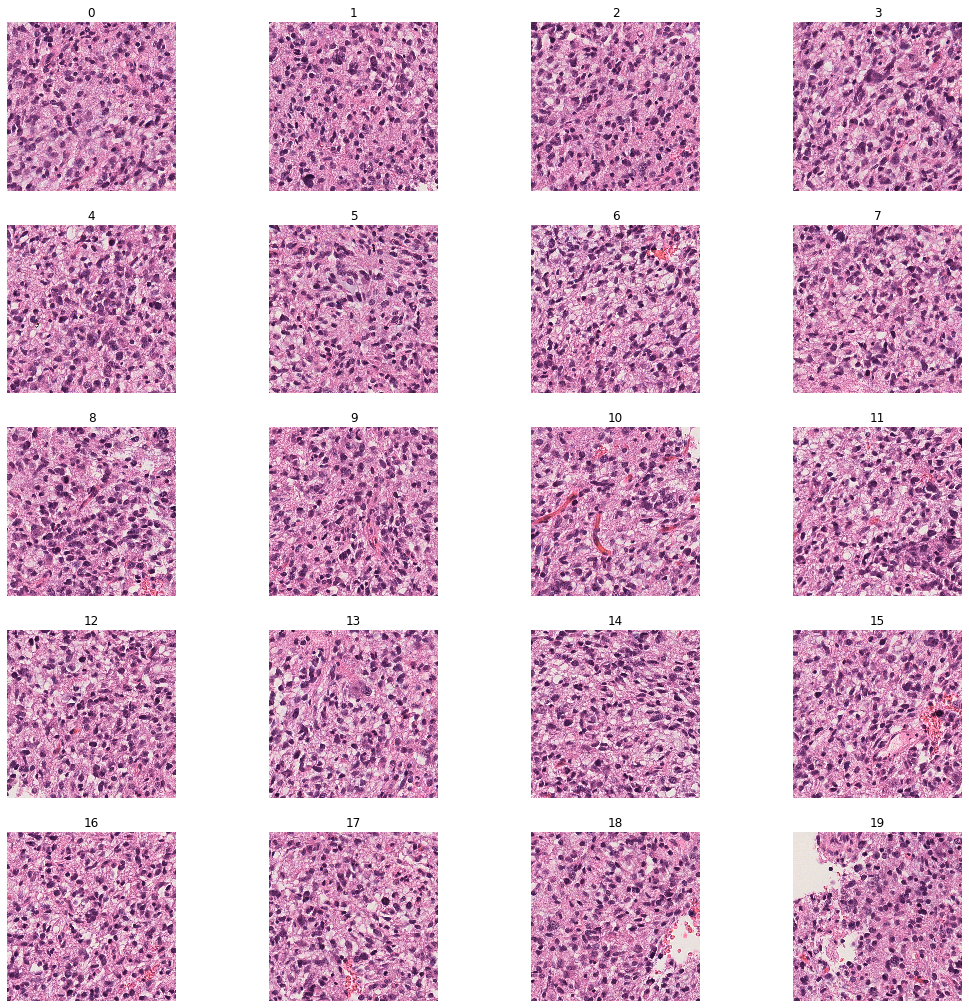

In [93]:
evaluator.plot_top_losses(dataset_type=shared.enums.DatasetType.validation, k=20, descending=True)

In [94]:
df_most_wrong_slides = evaluator.get_df_of_k_top_ordered_by_metric(dataset_type=shared.enums.DatasetType.validation, 
                                            level=shared.enums.EvaluationLevel.slide, 
                                            k=30)
df_most_wrong_slides

slide target predicted  \
0      N1105-08-3    [1]       [0]   
1       N785-19-1    [1]       [0]   
2        N1100-19    [1]       [0]   
3        N11-08-4    [1]       [0]   
4     N255-19-I-1    [1]       [0]   
5          N29-12    [0]       [1]   
6      N7-08-II-1    [1]       [0]   
7        N1020-19    [1]       [0]   
8         N655-19    [0]       [1]   
9       N554-10-1    [1]       [0]   
10      N750-08-2    [0]       [1]   
11   N1242-19-III    [0]       [0]   
12        N206-19    [0]       [0]   
13     N1416-18-5    [1]       [1]   
14      N179-09-1    [0]       [0]   
15   N212-09-II-2    [0]       [0]   
16     N2090-18-3    [1]       [1]   
17        N375-09    [1]       [1]   
18      N279-08-1    [0]       [0]   
19  N1149-19-II-1    [0]       [0]   
20       N1201-12    [0]       [0]   
21      N554-19-3    [1]       [1]   
22     N913-11-IV    [0]       [0]   
23    N2184-18-II    [0]       [0]   
24      N985-19-1    [0]       [0]   
25     N2139-18-3    [0]       [0]   
26        N822-09    [1]       [1]   
27       N1229-19    [0]       [0]   
28    N1108-19-II    [0]       [0]   

                                       probabilities    metric  
0   {0: 0.9753694581280788, 1: 0.022988505747126436}  0.976190  
1    {0: 0.9614791987673343, 1: 0.03697996918335902}  0.962250  
2      {0: 0.93717277486911, 1: 0.05759162303664921}  0.939791  
3    {0: 0.9098360655737705, 1: 0.08469945355191257}  0.912568  
4    {0: 0.8757763975155279, 1: 0.12422360248447205}  0.875776  
5    {0: 0.12622950819672132, 1: 0.8704918032786885}  0.872131  
6    {0: 0.7896414342629482, 1: 0.20876494023904382}  0.790438  
7     {0: 0.7428571428571429, 1: 0.2571428571428571}  0.742857  
8     {0: 0.3277777777777778, 1: 0.6722222222222223}  0.672222  
9    {0: 0.6387368421052632, 1: 0.35873684210526313}  0.640000  
10   {0: 0.44546347854569274, 1: 0.5512610547002947}  0.552899  
11     {0: 0.5320910973084886, 1: 0.463768115942029}  0.465839  
12    {0: 0.5396825396825397, 1: 0.4603174603174603}  0.460317  
13                              {0: 0.425, 1: 0.575}  0.425000  
14    {0: 0.5903387703889585, 1: 0.4084065244667503}  0.409034  
15    {0: 0.5934959349593496, 1: 0.4065040650406504}  0.406504  
16    {0: 0.3747534516765286, 1: 0.6153846153846154}  0.379684  
17    {0: 0.3510436432637571, 1: 0.6489563567362429}  0.351044  
18    {0: 0.6915113871635611, 1: 0.3022774327122153}  0.305383  
19   {0: 0.6938483547925608, 1: 0.29756795422031473}  0.301860  
20                               {0: 0.7, 1: 0.2875}  0.293750  
21    {0: 0.2570281124497992, 1: 0.7429718875502008}  0.257028  
22    {0: 0.7790055248618785, 1: 0.2154696132596685}  0.218232  
23   {0: 0.7857142857142857, 1: 0.21428571428571427}  0.214286  
24   {0: 0.8464912280701754, 1: 0.14035087719298245}  0.146930  
25   {0: 0.9063444108761329, 1: 0.09365558912386707}  0.093656  
26    {0: 0.09336332958380203, 1: 0.906636670416198}  0.093363  
27   {0: 0.9315673289183223, 1: 0.06622516556291391}  0.067329  
28   {0: 0.9571428571428572, 1: 0.04285714285714286}  0.042857